# Agreement Plots

In [1]:
from datetime import datetime as dt
import itertools

import cartopy.crs as ccrs
import cmocean.cm as cmo
import cool_maps.plot as cplt
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

import ggs2.maps as maps
import ggs2.models as models
import ggs2.model_processing as mp
import ggs2.pathfinding as pf
import ggs2.util as util

%matplotlib inline

In [2]:
sns.set_theme(context="poster", palette="colorblind")

## Parameters

In [3]:
thresholds = [90, 85, 80, 75, 70, 65, 60, 55, 50]
waypoints = [(33, -77), (39, -51)]

mission_name = "gulfstream"
date_dir = "2025_05_15"
date="2025051500"

model1 = models.CMEMS()
name1 = "CMEMS"

model2 = models.ESPC()
name2 = "ESPC"

model3 = models.RTOFS('east')
name3 = "RTOFS-east"

## Functions

### Masking Functions

In [4]:
def mask_bimodel_comparison(vector_diff, threshold):
    mask = vector_diff.where(vector_diff <= threshold, drop=True)
    mask.attrs["models"] = f"{vector_diff.attrs["model1_name"]}, {vector_diff.attrs['model2_name']}"
    return mask

def mask_trimodel_comparison(vector_diff_list, threshold):
    mask = vector_diff_list[0].where(
        (vector_diff_list[0] <= threshold) &
        (vector_diff_list[1] <= threshold) &
        (vector_diff_list[2] <= threshold), drop=True
    )
    mask.attrs["models"] = "CMEMS, ESPC, RTOFS (East)"
    return mask

Load Data

In [5]:
mlist = [model1, model2, model3]
nlist = [name1, name2, name3]

# load data
for n, m in zip(nlist, mlist):
    dpath = f"products/{date_dir}/data/{mission_name}_{date}_{n}_dac.nc"
    print(dpath)
    d = xr.open_dataset(dpath, engine="netcdf4")
    m.da_data = d

products/2025_05_15/data/gulfstream_2025051500_CMEMS_dac.nc
products/2025_05_15/data/gulfstream_2025051500_ESPC_dac.nc
products/2025_05_15/data/gulfstream_2025051500_RTOFS-east_dac.nc


Get difference data

In [6]:
model_combinations = list(itertools.combinations(mlist, 2))

diff_list = [mp.calculate_vector_diff(c[0], c[1], diag_text=False) for c in model_combinations]
diff_list[0]

<xarray.DataArray (lat: 326, lon: 351)> Size: 458kB
array([[179.76909 , 172.64355 , 162.05125 , ...,  99.608505,  93.178   ,
         85.44729 ],
       [178.86002 , 173.52435 , 166.35301 , ...,  86.495285,  82.249306,
         80.07025 ],
       [174.47481 , 167.4295  , 160.01602 , ...,  49.844463,  57.976204,
         66.85898 ],
       ...,
       [       nan,        nan,        nan, ..., 137.80655 , 127.48424 ,
        135.30516 ],
       [       nan,        nan,        nan, ..., 135.41876 , 122.32349 ,
        120.37317 ],
       [       nan,        nan,        nan, ..., 136.41531 , 120.63272 ,
        109.94439 ]], dtype=float32)
Coordinates:
    time     datetime64[ns] 8B 2025-05-15
  * lat      (lat) float64 3kB 32.0 32.04 32.08 32.12 ... 44.88 44.92 44.96 45.0
  * lon      (lon) float64 3kB -78.0 -77.92 -77.84 ... -50.16 -50.08 -50.0
Attributes:
    model_name:   CMEMS+ESPC_vector_diff
    text_name:    Vector Difference [CMEMS & ESPC]
    fname:        CMEMS+ESPC_vector_diff
    model1_name:  CMEMS
    model2_name:  ESPC

## Agreement Plots

In [7]:
extent = (
    float(model1.da_data.lat.min().values),
    float(model1.da_data.lon.min().values),
    float(model1.da_data.lat.max().values),
    float(model1.da_data.lon.max().values),
)
extent

(32.0, -78.0, 45.0, -50.0)

In [12]:
from matplotlib.lines import Line2D

def plot_agreement(
        vector_diff_list: list[xr.Dataset],
        threshold: float, 
        extent: list[float],
        fig: plt.Figure = None,
        ax: plt.Axes = None, 
        proj: ccrs.Projection = ccrs.Mercator(),
        colors: tuple[str, str] = ("lightgray", "green"),
        i: int = None
    ) -> tuple[plt.Figure, plt.Axes]:
    # check if ax is provided. If not, create one
    if ax is None or fig is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={"projection":proj})
    
    # set theme and colors
    sns.set_theme(context="poster", palette="colorblind")
    gray = ListedColormap(colors[0])
    green = ListedColormap(colors[1])

    cplt.create(extent=[extent[1], extent[3], extent[0], extent[2]], gridlines=True, ax=ax, proj=proj, oceancolor="none")
    if i is None:
        title = f"{threshold}% Difference"
    else:
        title = f"{i}: {threshold}% Difference"
    ax.set_title(title, y=1.03)

    # bimodel agreement
    for simple_diff in vector_diff_list:
        bimodel_mask = mask_bimodel_comparison(simple_diff, threshold)
        lon2D, lat2D = np.meshgrid(bimodel_mask.lon, bimodel_mask.lat)
        levels = np.linspace(bimodel_mask.min(), bimodel_mask.max(), 2)
        bimodel_cf = ax.contourf(lon2D, lat2D, bimodel_mask, levels=levels, cmap=gray, transform=ccrs.PlateCarree())
        bimodel_cf.set_alpha(0.4)
    
    # trimodel agreement
    trimodel_mask = mask_trimodel_comparison(vector_diff_list, threshold)
    lon2D, lat2D = np.meshgrid(trimodel_mask.lon, trimodel_mask.lat)
    levels = np.linspace(trimodel_mask.min(), trimodel_mask.max(), 2)
    trimodel_cf = ax.contourf(lon2D, lat2D, trimodel_mask, levels=levels, cmap=green, transform=ccrs.PlateCarree())

    return fig, ax

def single_agreement_plot(
        vector_diff_list: list[xr.Dataset], 
        threshold: tuple[float, float], 
        extent: list[float],
        paths: list = None,
        legend_loc: str = "bottom"
    ) -> plt.Figure:
    pal = sns.color_palette("colorblind")
    pal_hex = pal.as_hex()
    gray = pal_hex[7]
    green = pal_hex[2]
    path_colors = [pal_hex[0], pal_hex[1], pal_hex[3]]
    names = ["CMEMS", "ESPC", "RTOFS"]
    
    fig, ax = plot_agreement(vector_diff_list, threshold, extent, colors=(gray, green))

    patches = []
    patches.append(mpatches.Patch(color=gray, alpha=0.4, label="Bi-Model Agreement"))
    patches.append(mpatches.Patch(color=green, label="Tri-Model Agreement"))

    if paths is not None:
        for i, path in enumerate(paths):
            lons = list(path['lon'].values())
            lats = list(path['lat'].values())
            path_formatted = [(lat, lon) for lat, lon in zip(lats, lons)]
            path_plot = maps.create_glider_path(ax, path_formatted, waypoints, color=path_colors[i])
            # path_plot = ax.plot(lons, lats, linestyle='-', color=path_colors[i], linewidth=5, transform=ccrs.Geodetic(), label=names[i])
            patches.append(Line2D([],[], color=path_colors[i], label=names[i]))

    if legend_loc == "right":
        legend_coords = (1.135, 0.87)
        ncols = 1
        loc = None
    elif legend_loc == "bottom":
        legend_coords = (0.5, -0.03)
        ncols = 3
        loc = "lower center"
    legend = fig.legend(handles=patches, frameon=False, loc=loc, bbox_to_anchor=(legend_coords), ncol=ncols)

    return fig

def agreement_matrix(
        vector_diff_list: list[xr.Dataset],
        thresholds: list[float], 
        extent: list[float]
    ) -> plt.Figure:
    # set theme and colors
    sns.set_context("poster")
    pal = sns.color_palette("colorblind")
    pal_hex = pal.as_hex()
    gray = pal_hex[7]
    green = pal_hex[2]
    
    # plot
    fig, axes = plt.subplots(3, 3, figsize=(20, 14), subplot_kw={"projection":ccrs.Mercator()})
    for i, (ax, threshold) in enumerate(zip(axes.flatten(), thresholds)):
        plot_agreement(vector_diff_list, threshold, extent, fig=fig, ax=ax, colors=(gray, green), i=i)
    patches = []
    patches.append(mpatches.Patch(color=gray, alpha=0.4, label="Bi-Model Agreement"))
    patches.append(mpatches.Patch(color=green, label="Tri-Model Agreement"))
    legend = fig.legend(handles=patches, loc="lower center", frameon=False, bbox_to_anchor=(0.5, -0.05), ncol=5)
        
    plt.tight_layout()

    return fig

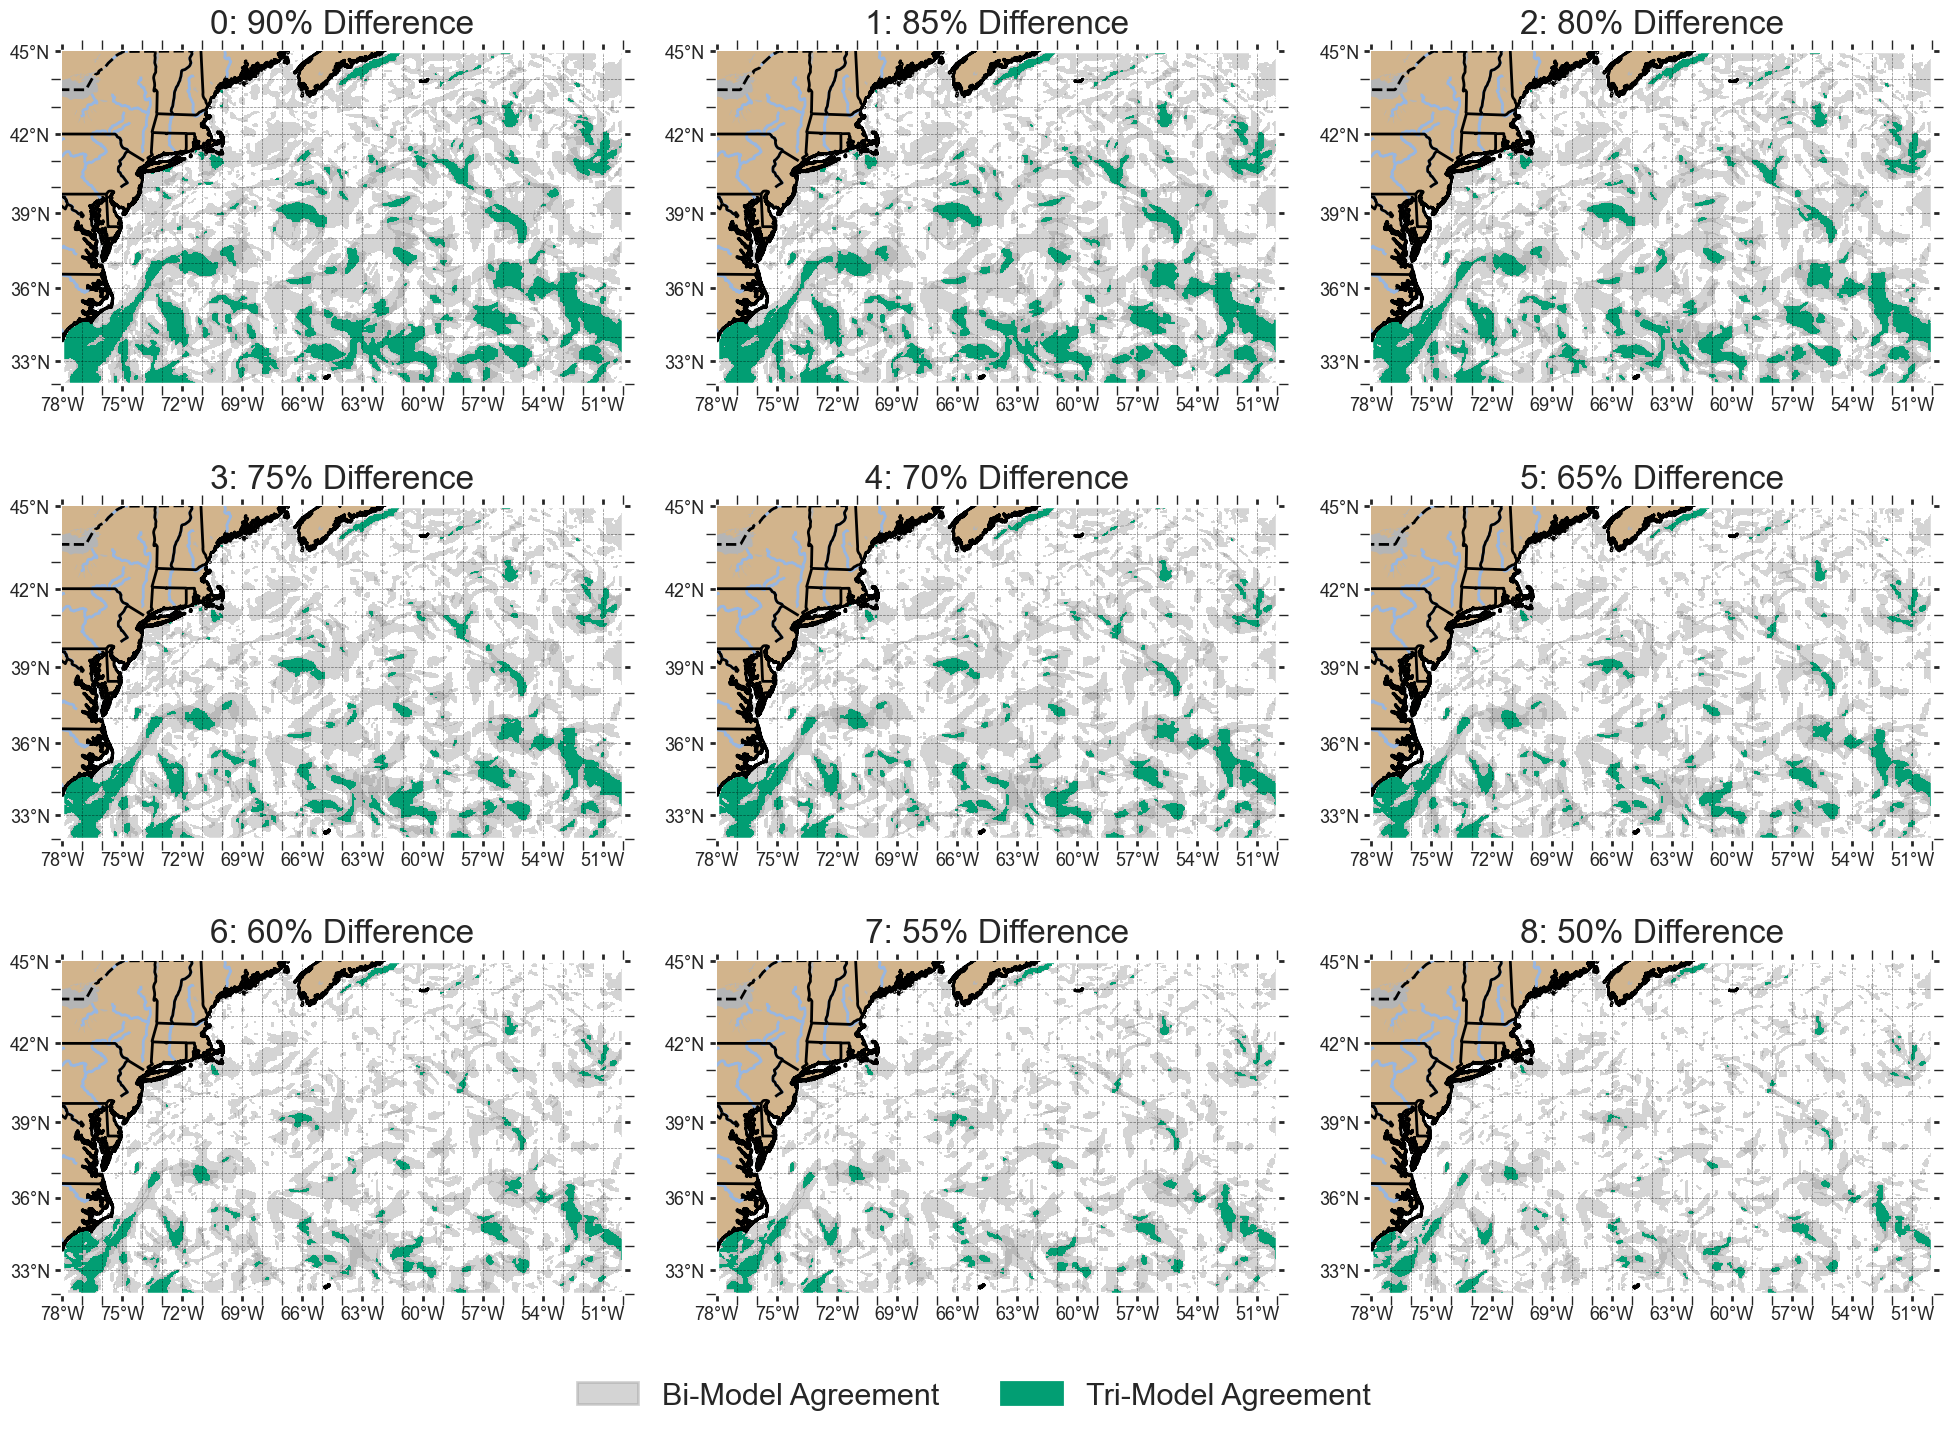

In [14]:
matrixfig = agreement_matrix(diff_list, thresholds, extent)
plt.savefig(f"products/{date_dir}/{mission_name}_agreement_matrix.png", dpi=600, bbox_inches="tight")

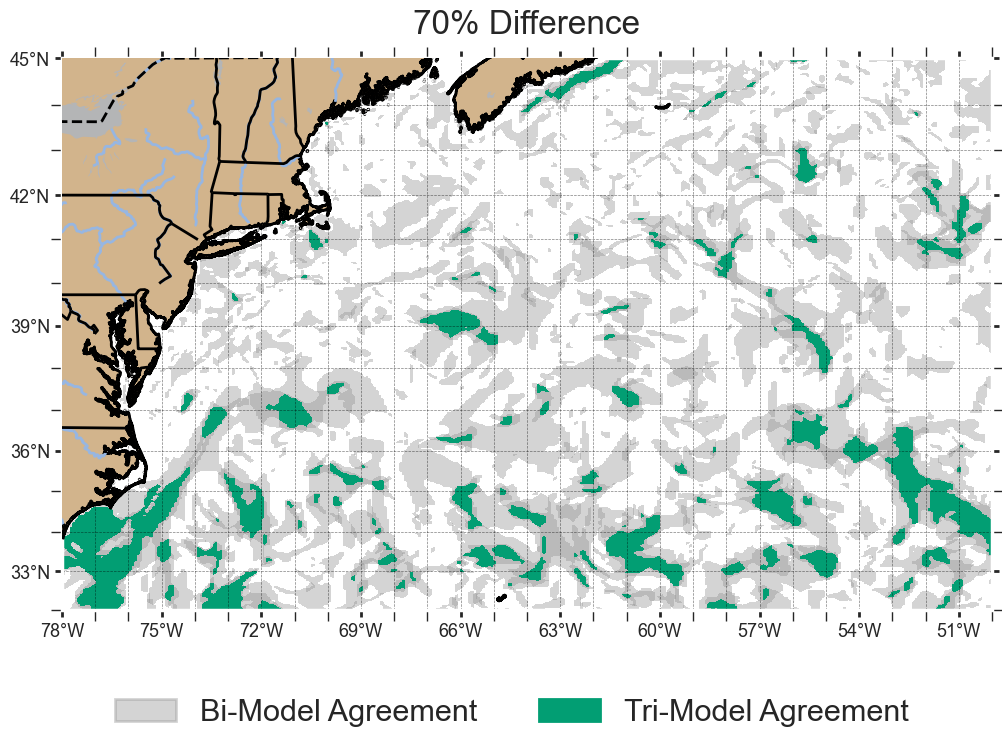

In [15]:
fig_number = 4
onefig = single_agreement_plot(diff_list, thresholds[fig_number], extent)
# plt.savefig(f"products/{date_dir}/{mission_name}_agreement_{fig_number}.png", dpi=600, bbox_inches="tight")

In [9]:
olist = []
for n in nlist:
    opath = f"products/{date_dir}/data/{mission_name}_{date}_{n}_mission_path.csv"
    o = pd.read_csv(opath).squeeze().to_dict()
    olist.append(o)

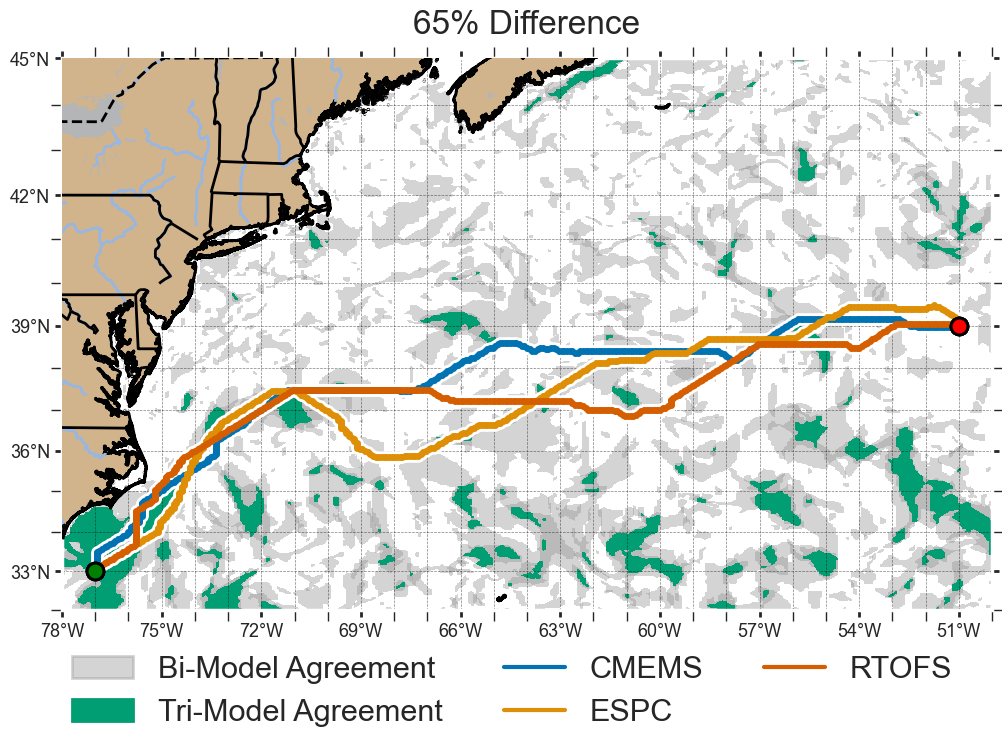

In [11]:
fig_number = 5
onefig_paths = single_agreement_plot(diff_list, thresholds[fig_number], extent, paths=olist)
plt.savefig("figure4.png", dpi=600, bbox_inches="tight")